In [1]:
#!pip install -e .. > /dev/null 2>&1

In [2]:
import os
import json
import astrohack
import toolviper

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
#!rm -rf data/ results

In [4]:
def build_folder_structure(paths):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path) 

base_name = 'ea25_cal_small_'

datafolder = 'data'
resultsfolder = 'results'

# Build folder structure & download 
build_folder_structure(['data', 'results'])

toolviper.utils.data.download(file='ea25_cal_small_before_fixed.split.ms', folder=datafolder)
toolviper.utils.data.download(file='ea25_cal_small_after_fixed.split.ms', folder=datafolder)

toolviper.utils.data.download(file='extract_holog_verification.json')
toolviper.utils.data.download(file='holog_numerical_verification.json')

[2024-04-29 13:45:26,488]     INFO  toolviper:  File exists: data/ea25_cal_small_before_fixed.split.ms 
[2024-04-29 13:45:26,489]     INFO  toolviper:  File exists: data/ea25_cal_small_after_fixed.split.ms 
[2024-04-29 13:45:26,490]     INFO  toolviper:  File exists: extract_holog_verification.json 
[2024-04-29 13:45:26,490]     INFO  toolviper:  File exists: holog_numerical_verification.json 


In [5]:
from toolviper.dask.client import local_client

log_params = {
    'logger_name': 'astrohack',
    'log_level':'DEBUG',
    'log_to_term': True
}

worker_log_params = {
    'log_level':'DEBUG',
    'log_file': None,
    'log_to_term': True,
    'log_to_file': False
}

client = local_client(
    cores=2, 
    memory_limit='8GB', 
    log_params=log_params,
    worker_log_params=worker_log_params
)

[2024-04-29 13:45:26,534]     INFO  toolviper:  Checking parameter values for client.local_client 
[2024-04-29 13:45:26,535]     INFO  toolviper:  Module path: /users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10//site-packages/ 
[2024-04-29 13:45:26,536]     INFO  toolviper:  Searching /users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10/site-packages/toolviper/config/ for configuration file, please wait ... 
[2024-04-29 13:45:26,540]  WARNING   astrohack:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 


/users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41857 instead
  warnings.warn(


[2024-04-29 13:45:27,631]    DEBUG   astrohack:  These are the worker log parameters:
 {'logger_name': 'worker', 'log_to_term': True, 'log_level': 'DEBUG', 'log_to_file': False, 'log_file': None}
[2024-04-29 13:45:27,632]    DEBUG   astrohack:  Loading plugin module: <class 'worker.DaskWorker'>
[2024-04-29 13:45:27,633]    DEBUG   astrohack:  worker
[2024-04-29 13:45:27,672]    DEBUG    worker_1:  Logger created on worker Worker-190289d4-16e3-4389-b4b8-ec7520543f94,*,tcp://127.0.0.1:35935
[2024-04-29 13:45:27,672]    DEBUG    worker_0:  Logger created on worker Worker-67119311-e6f6-4631-a35d-4108f90d5bae,*,tcp://127.0.0.1:41417
[2024-04-29 13:45:27,673]     INFO   astrohack:  Created client <MenrvaClient: 'tcp://127.0.0.1:43319' processes=2 threads=2, memory=14.90 GiB> 


In [6]:
def test_holog_obs_dictionary(holog_obs_dict):
    import os
    import json
    import copy
    
    import numpy as np

    with open(".holog_obs_dict.json") as json_file:
        holog_obj = json.load(json_file)
                          
    assert json.loads(holog_obj) == holog_obs_dict, "Error: holog_obs_description dictionary has changes unexpectedly."
    
def test_holog_diagnostics(json_data, tolerance=1e-7):
    import json
    
    with open("holog_numerical_verification.json") as file:
        reference_dict = json.load(file)
        
    cell_size = reference_dict["vla"]['cell_size'][1]
    grid_size = float(reference_dict["vla"]['grid_size'][1])
    
    json_data['cell_size'] = np.abs(float(json_data['cell_size']))
    
    cell_size = np.abs(float(cell_size))
    
    assert relative_difference(json_data['cell_size'], cell_size) < tolerance, "Unexpected change in cell_size occured."
    assert relative_difference(int(np.sqrt((json_data['n_pix']))), grid_size) < tolerance, "Unexpected change in grid_size occured."

    
def test_center_pixel(file, antenna, ddi, reference_center_pixels, number_of_digits=7):
    from astrohack.dio import open_image
    
    mds = open_image(file)[antenna][ddi]
    
    aperture_shape = mds.APERTURE.values.shape[-2], mds.APERTURE.values.shape[-1]
    beam_shape = mds.BEAM.values.shape[-2], mds.BEAM.values.shape[-1]    
    
    aperture_center_pixels = np.squeeze(mds.APERTURE.values[..., aperture_shape[0]//2, aperture_shape[1]//2])
    beam_center_pixels = np.squeeze(mds.BEAM.values[..., beam_shape[0]//2, beam_shape[1]//2])
    
    aperture_ref = list(map(complex, reference_center_pixels['aperture']))
    beam_ref = list(map(complex, reference_center_pixels['beam']))

    
    
    for i in range(len(aperture_ref)):        
        assert relative_difference(
            aperture_ref[i].real, 
            aperture_center_pixels[i].real
        ) < 1.5e-6, "There has been a shift in aperture center pixel value(s)"
        
        assert relative_difference(
            beam_ref[i].real, 
            beam_center_pixels[i].real
        ) < 1.5e-6, "There has been a shift in beam center pixel value(s)"
                
        assert relative_difference(
            aperture_ref[i].imag, 
            aperture_center_pixels[i].imag
        ) < 1.5e-6, "There has been a shift in aperture center pixel value(s)"
        assert relative_difference(
            beam_ref[i].imag, 
            beam_center_pixels[i].imag
        ) < 1e-6, "There has been a shift in beam center pixel value(s)"
        
              
def get_center_pixel(file, antenna, ddi):
    from astrohack.dio import open_image
    
    mds = open_image(file)[antenna][ddi]
    
    aperture_shape = mds.APERTURE.values.shape[-2], mds.APERTURE.values.shape[-1]
    beam_shape = mds.BEAM.values.shape[-2], mds.BEAM.values.shape[-1]    
    
    aperture_center_pixels = mds.APERTURE.values[..., aperture_shape[0]//2, aperture_shape[1]//2]
    beam_center_pixels = mds.BEAM.values[..., beam_shape[0]//2, beam_shape[1]//2]
    
    return np.squeeze(aperture_center_pixels), np.squeeze(beam_center_pixels)

def compare_float_values(result, reference, decimals):
    result_list = list(map(str, str(result)))
    reference_list = list(map(str, str(reference)))
    
    return result_list[:decimals] == reference_list[:decimals]

def relative_difference(result, expected):
    return 2*np.abs(result - expected)/(abs(result) + abs(expected))

In [7]:
from astrohack.extract_pointing import extract_pointing

before_ms = datafolder+'/'+ base_name + 'before_fixed.split.ms'
after_ms =  datafolder+'/'+ base_name + 'after_fixed.split.ms'

before_point = resultsfolder+'/before.split.point.zarr'
after_point = resultsfolder+'/after.split.point.zarr'

point_mds = extract_pointing(
      ms_name=before_ms,
      point_name=before_point,
      parallel=False,
      overwrite=True
)

holog_mds = extract_pointing(
      ms_name=after_ms,
      point_name=after_point,
      parallel=False,
      overwrite=True
)

[2024-04-29 13:45:27,696]     INFO   astrohack:  Checking parameter values for extract_pointing.extract_pointing 
[2024-04-29 13:45:27,696]     INFO   astrohack:  Module path: /export/home/fornax/Development/astrohack-issue-250/ 
[2024-04-29 13:45:27,697]     INFO   astrohack:  Searching /users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10/site-packages/toolviper/config/ for configuration file, please wait ... 
[2024-04-29 13:45:27,697]    DEBUG   astrohack:  Result: None
[2024-04-29 13:45:27,697]     INFO   astrohack:  Searching /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config/ for configuration file, please wait ... 
[2024-04-29 13:45:27,698]    DEBUG   astrohack:  Result: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:45:27,698]    DEBUG   astrohack:  PARAMETER_CONFIG_PATH: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:45:27,698]    DEBUG   astrohack:  /export/home/f

In [9]:
from astrohack.extract_holog import extract_holog
import numpy as np

before_holog = resultsfolder+'/before.split.holog.zarr'
after_holog = resultsfolder+'/after.split.holog.zarr'

holg_mds = extract_holog(
    ms_name=before_ms,
    point_name=before_point,
    holog_name=before_holog,
    #ddi=[0],
    #baseline_average_distance=50.1,
    #baseline_average_nearest=1,
    data_column='CORRECTED_DATA',
    parallel=False,
    overwrite=True
)

holg_mds = extract_holog(
    ms_name=after_ms,
    point_name=after_point,
    holog_name=after_holog,
    #ddi=[0],
    #baseline_average_distance=50.1,
    #baseline_average_nearest=1,
    data_column='CORRECTED_DATA',
    parallel=False,
    overwrite=True
)


[2024-04-29 13:45:32,390]     INFO   astrohack:  Checking parameter values for extract_holog.extract_holog 
[2024-04-29 13:45:32,391]     INFO   astrohack:  Module path: /export/home/fornax/Development/astrohack-issue-250/ 
[2024-04-29 13:45:32,391]     INFO   astrohack:  Searching /users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10/site-packages/toolviper/config/ for configuration file, please wait ... 
[2024-04-29 13:45:32,392]    DEBUG   astrohack:  Result: None
[2024-04-29 13:45:32,392]     INFO   astrohack:  Searching /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config/ for configuration file, please wait ... 
[2024-04-29 13:45:32,393]    DEBUG   astrohack:  Result: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:45:32,393]    DEBUG   astrohack:  PARAMETER_CONFIG_PATH: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:45:32,393]    DEBUG   astrohack:  /export/home/fornax/

In [ ]:
list(holog_mds.keys())

In [10]:
import numpy as np
from astrohack import holog

grid_interpolation_mode = 'linear' #'nearest' 'linear' 'cubic'
chan_average = True
scan_average = True

holog(
    holog_name=before_holog,
    image_name="results/before.split.image.zarr",
    padding_factor=50, 
    grid_size=[29, 29],
    grid_interpolation_mode=grid_interpolation_mode,
    chan_average = chan_average,
    scan_average = scan_average,
    overwrite=True,
    phase_fit_engine="perturbations",
    apply_mask=True,
    to_stokes=True,
    parallel=True
)

image_mds = holog(
    holog_name=after_holog,
    image_name="results/after.split.image.zarr",
    padding_factor=50, 
    grid_size=[29, 29],
    grid_interpolation_mode=grid_interpolation_mode,
    chan_average = chan_average,
    scan_average = scan_average,
    overwrite=True,
    phase_fit_engine="perturbations",
    apply_mask=True,
    to_stokes=True,
    parallel=True
)


[2024-04-29 13:46:04,179]     INFO   astrohack:  Checking parameter values for holog.holog 
[2024-04-29 13:46:04,180]     INFO   astrohack:  Module path: /export/home/fornax/Development/astrohack-issue-250/ 
[2024-04-29 13:46:04,180]     INFO   astrohack:  Searching /users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10/site-packages/toolviper/config/ for configuration file, please wait ... 
[2024-04-29 13:46:04,181]    DEBUG   astrohack:  Result: None
[2024-04-29 13:46:04,181]     INFO   astrohack:  Searching /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config/ for configuration file, please wait ... 
[2024-04-29 13:46:04,181]    DEBUG   astrohack:  Result: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:46:04,182]    DEBUG   astrohack:  PARAMETER_CONFIG_PATH: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:46:04,182]    DEBUG   astrohack:  /export/home/fornax/Development/astr

In [13]:
with open("extract_holog_verification.json") as file:
    json_dict = json.load(file)

holog_obs_dict = json_dict["vla"]

test_holog_obs_dictionary(holog_obs_dict["after"])


with open(resultsfolder+'/after.split.holog.zarr/.holog_attr') as attr_file:
    holog_attr = json.load(attr_file)
    
test_holog_diagnostics(
    json_data=holog_attr,
    tolerance=5e-5
)

with open("holog_numerical_verification.json") as file:
    reference_dict = json.load(file)

test_center_pixel(
    file="results/before.split.image.zarr", 
    antenna="ant_ea25", 
    ddi="ddi_0", 
    reference_center_pixels=reference_dict["vla"]["pixels"]["before"]
)


test_center_pixel(
    file="results/after.split.image.zarr", 
    antenna="ant_ea25", 
    ddi="ddi_0", 
    reference_center_pixels=reference_dict["vla"]["pixels"]["after"]
)


In [ ]:
holog_obs_dict["after"]

-15.55624860106476 15.55624860106476


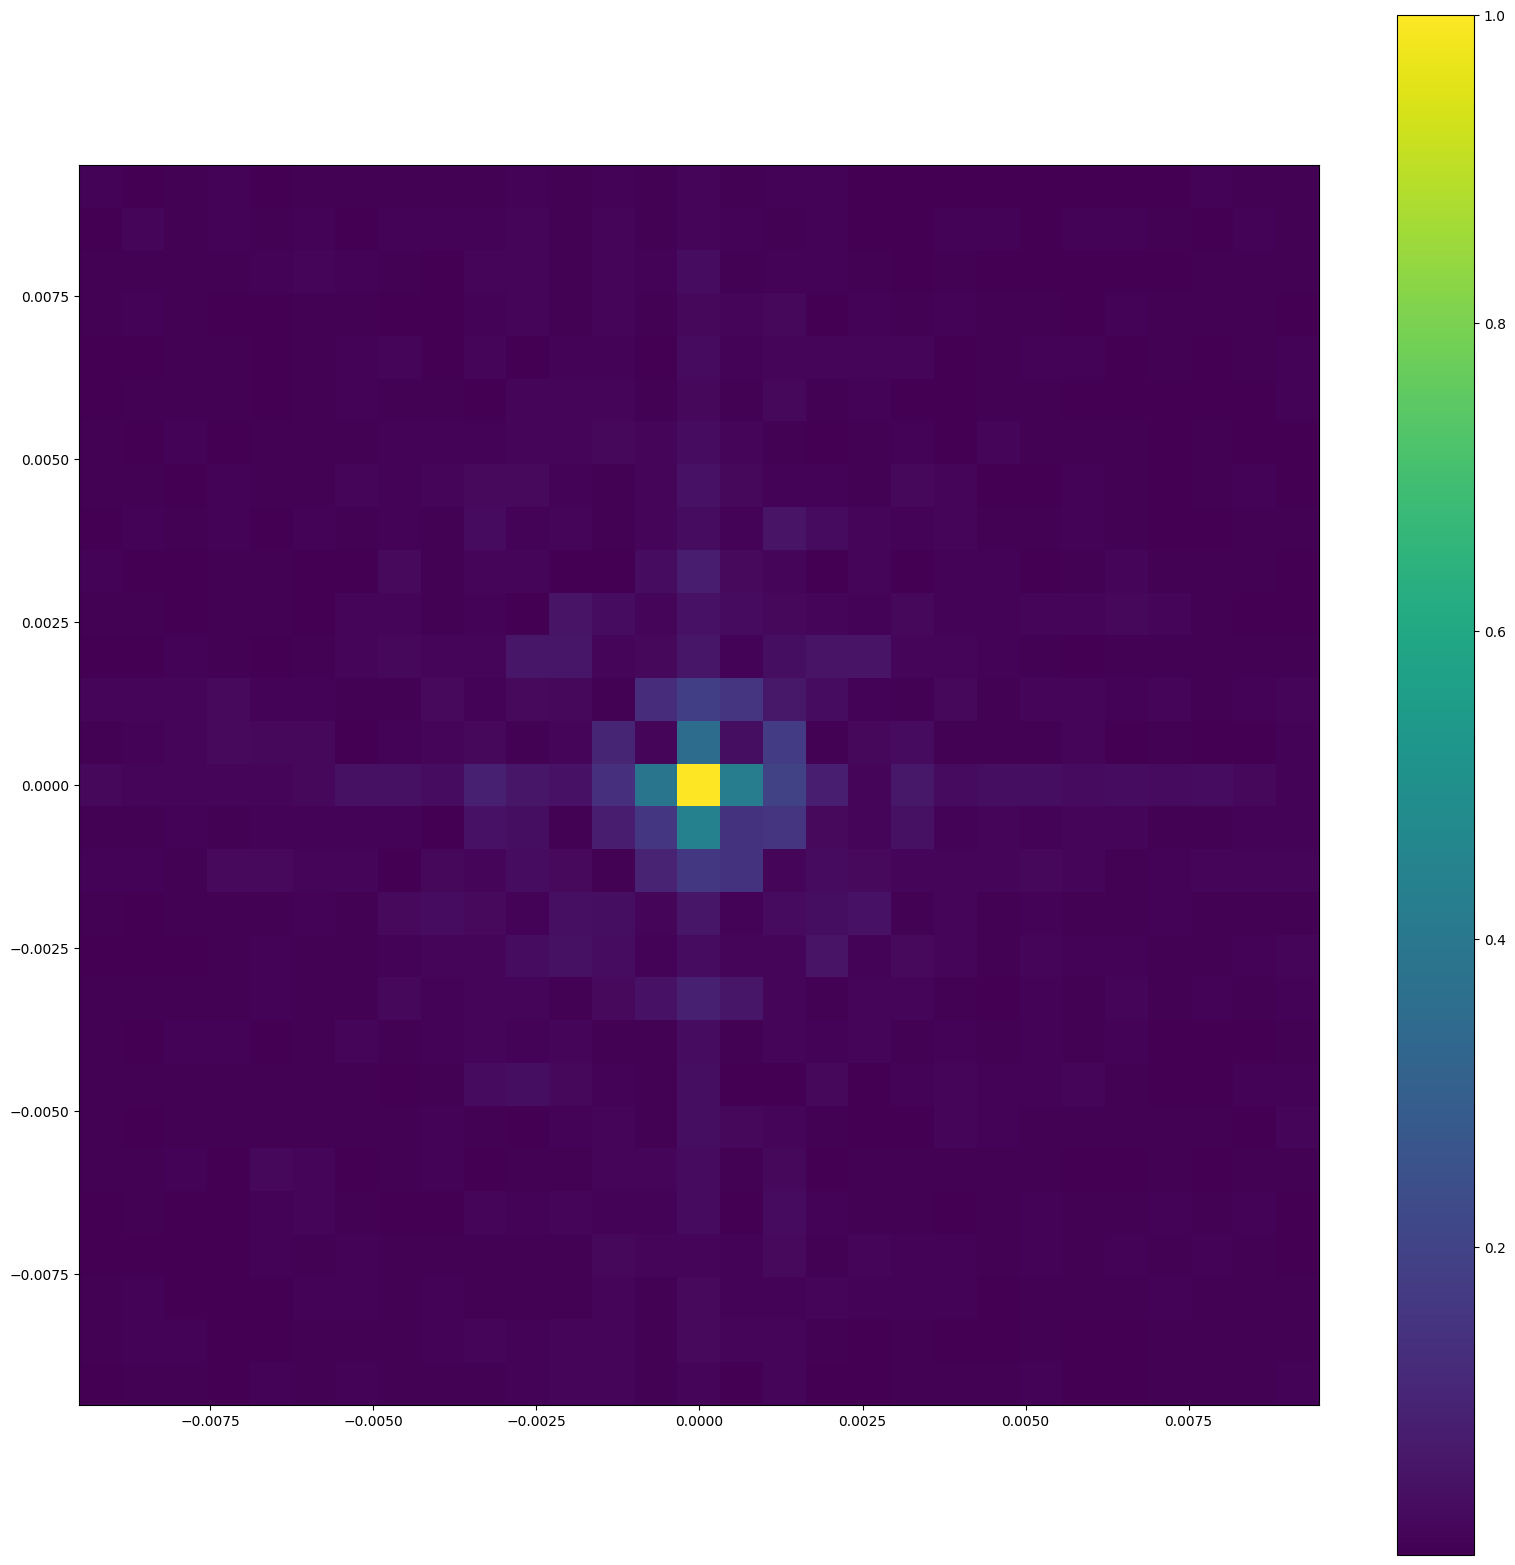

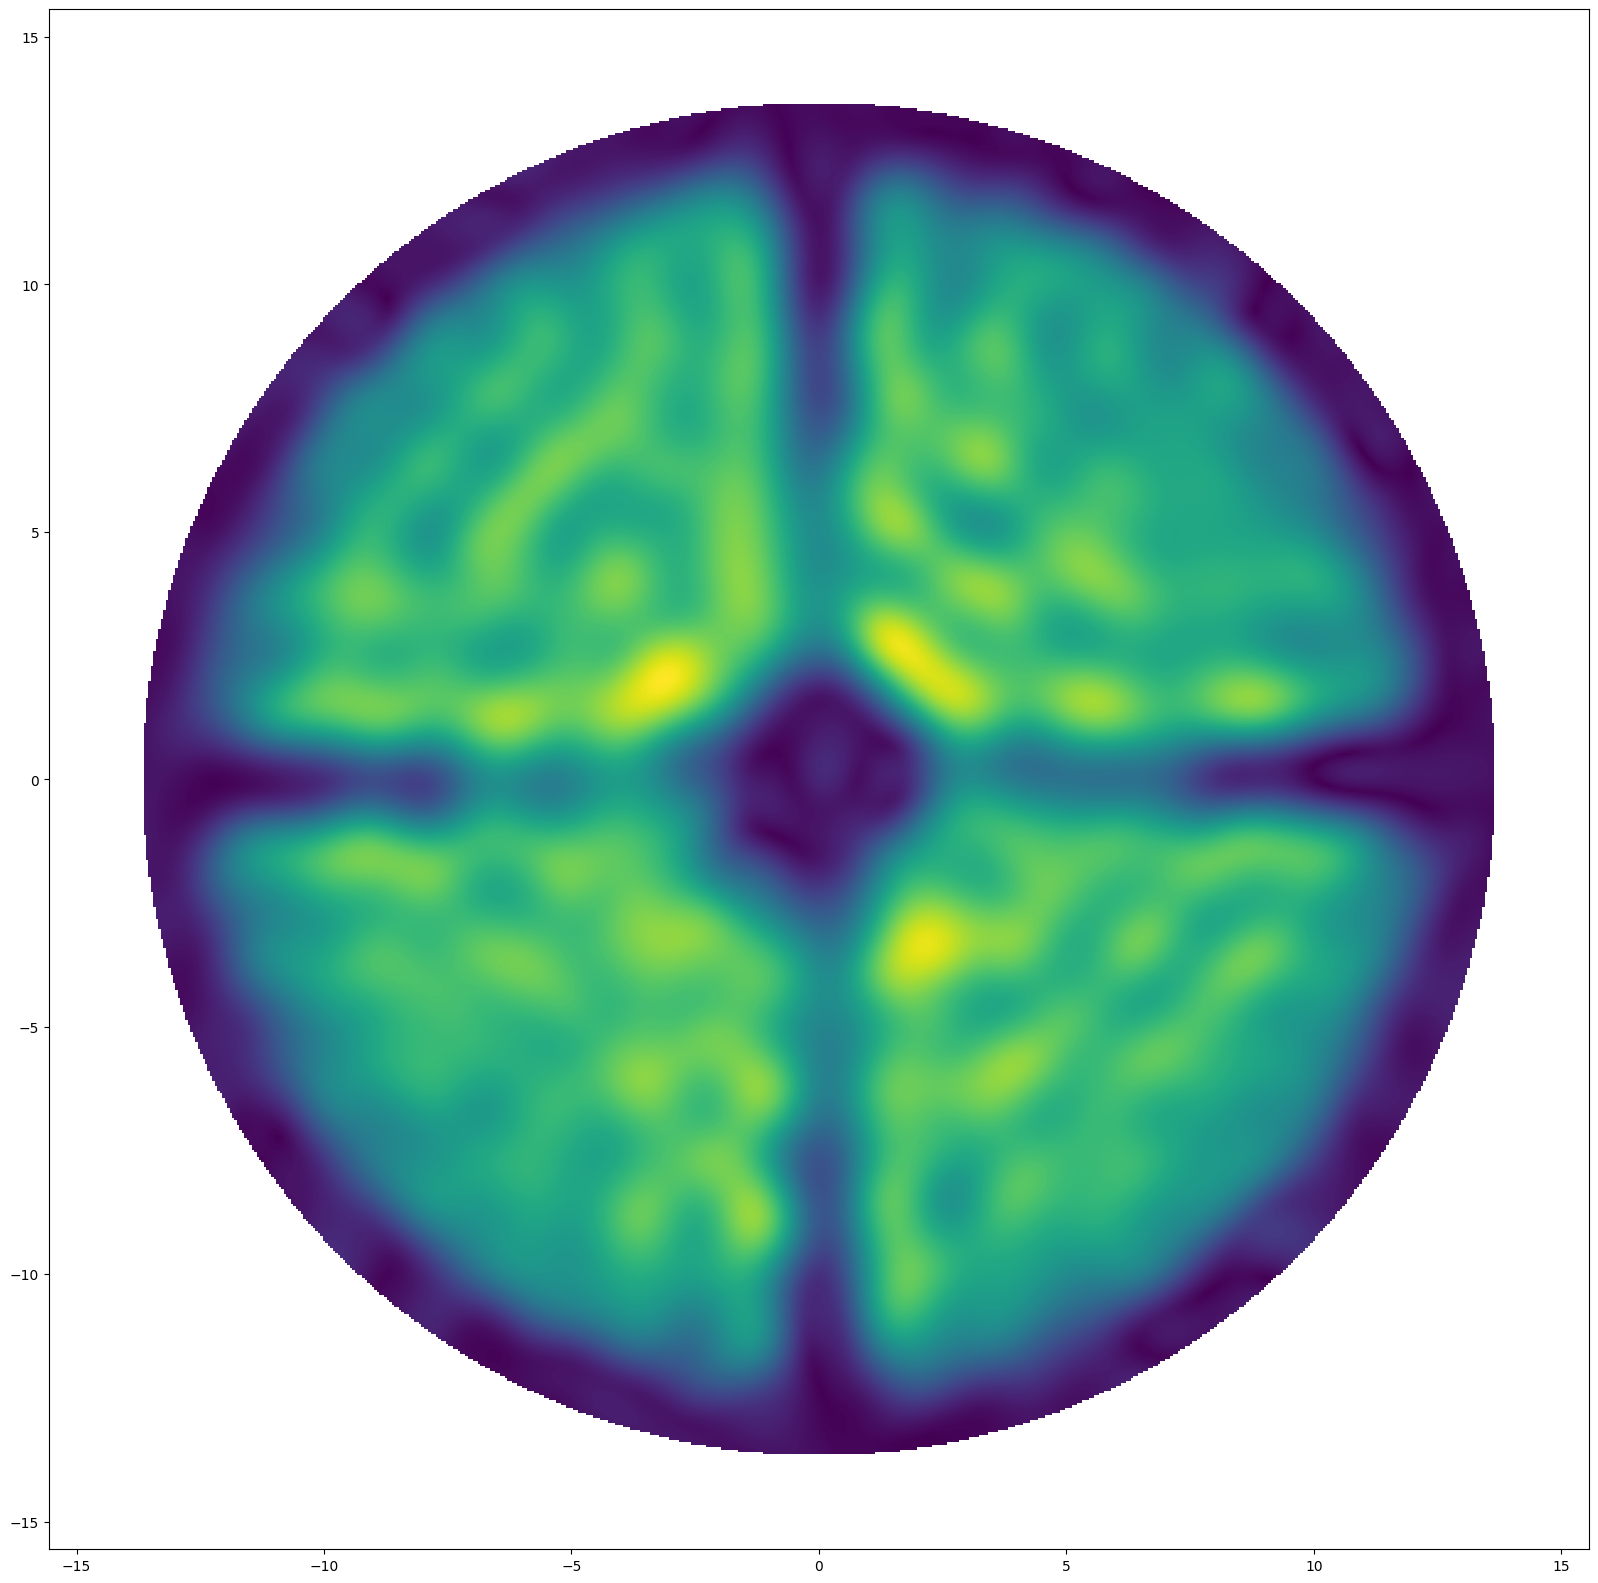

<xarray.Dataset> Size: 45MB
Dimensions:          (time: 1, chan: 1, pol: 4, u_prime: 552, v_prime: 552,
                      u: 627, v: 627, l: 29, m: 29, ddi: 1)
Coordinates:
  * chan             (chan) float64 8B 1.417e+10
  * ddi              (ddi) <U5 20B 'ddi_0'
  * l                (l) float64 232B 0.009507 0.008828 ... -0.008828 -0.009507
  * m                (m) float64 232B -0.009507 -0.008828 ... 0.008828 0.009507
  * pol              (pol) <U1 16B 'I' 'Q' 'U' 'V'
  * u                (u) float64 5kB 735.1 732.8 730.4 ... -730.4 -732.8 -735.1
  * u_prime          (u_prime) float64 4kB 648.2 645.9 643.5 ... -643.5 -645.9
  * v                (v) float64 5kB -735.1 -732.8 -730.4 ... 730.4 732.8 735.1
  * v_prime          (v_prime) float64 4kB -648.2 -645.9 -643.5 ... 643.5 645.9
Dimensions without coordinates: time
Data variables:
    AMPLITUDE        (time, chan, pol, u_prime, v_prime) float64 10MB dask.array<chunksize=(1, 1, 1, 276, 276), meta=np.ndarray>
    APERTURE         (time, chan, pol, u, v) complex128 25MB dask.array<chunksize=(1, 1, 1, 157, 314), meta=np.ndarray>
    BEAM             (time, chan, pol, l, m) complex128 54kB dask.array<chunksize=(1, 1, 4, 29, 29), meta=np.ndarray>
    CORRECTED_PHASE  (time, chan, pol, u_prime, v_prime) float64 10MB dask.array<chunksize=(1, 1, 1, 276, 276), meta=np.ndarray>
Attributes:
    ant_id:               ant_ea25
    ant_name:             ea25
    aperture_resolution:  [1.413428251773375, 1.413428251773375]
    ddi:                  ddi_0
    phase_fitting:        {'map_0': {'14167000000.0': {'RR': {'phase_offset':...
    telescope_name:       EVLA
    time_centroid:        5169758921.0

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy
import matplotlib.patches as patches

from scipy import constants

from astrohack.dio import open_image

before_image = resultsfolder+'/before.split.image.zarr'
after_image = resultsfolder+'/after.split.image.zarr'

plt.close('all')

chan = 0

ds = open_image("results/before.split.image.zarr")['ant_ea25']['ddi_0']

wavelength = scipy.constants.speed_of_light/ds.chan.values[chan]
l = ds.l.values
m = ds.m.values
u = ds.u.values*wavelength
v = ds.v.values*wavelength

print(u.min(),u.max())

plt.figure()
plt.imshow(np.abs(ds.BEAM[0,chan,0,:,:]),extent=[l.min(), l.max(), m.min(), m.max()])
plt.colorbar()
plt.show()

circle = patches.Circle((0,0), 12.5, fill=False, color='white', alpha=0.7, linewidth=2)

fig, ax =plt.subplots()
plt.imshow(np.abs(ds.APERTURE[0,chan,0,:,:]),extent=[u.min(), u.max(), v.min(), v.max()])

plt.show()

ds

In [15]:
from astrohack.panel import panel

panel_model = 'rigid'

before_panel = panel(
    image_name=before_image,
    panel_name="results/before.split.panel.zarr",
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)
after_panel = panel(
    image_name=after_image, 
    panel_name="results/after.split.panel.zarr",
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)

[2024-04-29 13:49:08,091]     INFO   astrohack:  Checking parameter values for panel.panel 
[2024-04-29 13:49:08,092]     INFO   astrohack:  Module path: /export/home/fornax/Development/astrohack-issue-250/ 
[2024-04-29 13:49:08,093]     INFO   astrohack:  Searching /users/jhoskins/fornax/miniconda3/envs/issue-250/lib/python3.10/site-packages/toolviper/config/ for configuration file, please wait ... 
[2024-04-29 13:49:08,094]    DEBUG   astrohack:  Result: None
[2024-04-29 13:49:08,094]     INFO   astrohack:  Searching /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config/ for configuration file, please wait ... 
[2024-04-29 13:49:08,094]    DEBUG   astrohack:  Result: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:49:08,095]    DEBUG   astrohack:  PARAMETER_CONFIG_PATH: /export/home/fornax/Development/astrohack-issue-250/src/astrohack/config
[2024-04-29 13:49:08,095]    DEBUG   astrohack:  /export/home/fornax/Development/astr

In [16]:
import numpy as np
from astrohack.dio import open_panel

def relative_difference(mean, expected):  
    return 2*np.abs(mean - expected)/(abs(mean) + abs(expected))

def verify_panel_shifts(
    panel_list=['3-4', '5-27', '5-37', '5-38'], 
    expected_shift=np.array([-100, 75, 0, 150]),
    ref_mean_shift = np.array([-77.8000519, 49.8347927, -0.0476941708, 100.268957]),
    antenna='ant_ea25',
    ddi='ddi_0'
):
    
    M_TO_MILS = 39370.1
    
    before_mds = open_panel('results/before.split.panel.zarr')
    after_mds = open_panel('results/after.split.panel.zarr')
    
    before_shift = before_mds[antenna][ddi].sel(labels=panel_list).PANEL_SCREWS.values*M_TO_MILS
    after_shift = after_mds[antenna][ddi].sel(labels=panel_list).PANEL_SCREWS.values*M_TO_MILS
    
    difference = after_shift - before_shift
    
    mean_shift = np.mean(difference, axis=1)
    
    delta_mean_shift = np.abs(mean_shift - expected_shift)
    delta_ref_shift = np.abs(ref_mean_shift - expected_shift)
        
    delta_shift = delta_mean_shift - delta_ref_shift  # New corrections - old corrections --> delta if delta < 0 ==> we improved.
    relative_shift = relative_difference(delta_mean_shift, delta_ref_shift)
       
    if np.any(relative_shift > 1e-6): 
        print("There were changes!")
        for i, delta in enumerate(delta_shift):
            if delta < 0:
                print("{panel}, improved by {delta} mils".format(panel=panel_list[i], delta=delta))
            else:
                print("{panel}, got worse by {delta} mils".format(panel=panel_list[i], delta=delta))

In [17]:
verify_panel_shifts()

There were changes!
3-4, improved by -2.1169829389725976 mils
5-27, got worse by 1.783375869861743 mils
5-37, got worse by 4.9189164774942125 mils
5-38, improved by -6.914288326992477 mils
